# **L2 norm on a test set**
Tale norma L2 viene presa come la norma massima 

In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import sys
import os
import json

# Import user-defined libraries:
sys.path.append(os.path.abspath('/Users/martina/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Git/rom-cylinder_DEIM-POD/offline-online stages/fit White/0. full order'))
from FreeFEM import FFmatrix_fread, FFvector_fread
from solver_class import FiniteElementCylinderSolver, ReducedBasisCylinderSolver

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_5052/2813527632.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_5052/2813527632.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


## **L2 norm varying the number of modes**

In [2]:
# Define size of the test parameter set:
FISSION_ENERGY = 3.215E-11
sTR = 100

# Define parameters ranges:
MIN_FR, MAX_FR = 2.00E+19, 3.00E+19 
MIN_BC, MAX_BC = 1.75E+03, 2.5E+03
MIN_LL, MAX_LL = 0.75E-3, 1.25E-3
MIN_RR, MAX_RR = 0.75E-5, 1.25E-5
MIN_FY, MAX_FY = 0.00, 0.3 
MIN_K, MAX_K =  0.9, 8                                                       

# Compute a list of random parameters within the range:
LIST_FR = np.random.uniform(low=MIN_FR, high=MAX_FR, size=(sTR))
LIST_BC = np.random.uniform(low=MIN_BC, high=MAX_BC, size=(sTR))
LIST_LL = np.random.uniform(low=MIN_LL, high=MAX_LL, size=(sTR))
LIST_RR = np.random.uniform(low=MIN_RR, high=MAX_RR, size=(sTR))
LIST_FY = np.random.uniform(low=MIN_FY, high=MAX_FY, size=(sTR))
LIST_K = np.random.uniform(low=MIN_K, high=MAX_K, size=(sTR))
LIST_GG = (LIST_FR * FISSION_ENERGY * LIST_LL**2)/LIST_K

In [ ]:
max_errors_L2 = []
dimensions = [1, 10, 57]
#list(range(1, 3))  # Da 1 a 57

MM_FO = np.load('model_files/XX_FO.npy', allow_pickle=True)[0]  # Matrice per norma L2
with h5py.File('../2. DEIM-POD/matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    ZZ_CO = hf['ZZ_CO'][:]
    II_CO = hf['II_CO'][:]

# Itera sulle dimensioni delle basi ridotte
for dim in dimensions:
    max_error_for_dim = 0  # Errore massimo per la dimensione corrente

    # Itera sui set di parametri
    for i in range(3):
        cur_FR = LIST_FR[i]
        cur_BC = LIST_BC[i]
        cur_LL = LIST_LL[i]
        cur_RR = LIST_RR[i]
        cur_FY = LIST_FY[i]
        cur_K = LIST_K[i]
        cur_dt = 1.00E+04

        print(f"Iterazione {i+1}/{sTR} - Parametri: "
          f"FR={cur_FR:.2e}, BC={cur_BC:.2f}, LL={cur_LL:.2e}, "
          f"RR={cur_RR:.2e}, FY={cur_FY:.2f}, K={cur_K:.2f}")
    
        # Calcola la soluzione FOM con i parametri attuali
        solver_FO = FiniteElementCylinderSolver()
        solver_FO.assemble(RADIUS=cur_RR, LENGTH=cur_LL, F_RATE=cur_FR, 
                        F_YIELD=cur_FY, T_BC=cur_BC, KTH=cur_K, dt=cur_dt)
        solution_FO = solver_FO.solve(n_steps=1000, verbose=False)

        # Ricrea CC_CO per il set di parametri
        GAMMA_T = (cur_FR * FISSION_ENERGY * cur_LL**2) / cur_K
        SOURCE_C = cur_FR * cur_FY
        TT = cur_BC + GAMMA_T * (1 - ZZ_CO**2) / 2
        WW = 2.949513e-13 * np.exp(-20487.36244 / TT)
        CC_CO = np.hstack((II_CO @ WW / cur_RR**2, II_CO @ WW / cur_LL**2))

        # Carica le matrici ridotte
        with h5py.File('../2. DEIM-POD/matrici_RB.h5', 'r') as hf:
            MM_RB = hf['MM_RB'][:dim, :dim]
            FF_RB = hf['FF_RB'][:dim]
            KK_RB = hf['KK_RB'][:, :dim, :dim]
            AA_RB = hf['AA_RB'][:dim]
            basis = hf['basis'][:, :dim]
        
        # Inizializzazione della soluzione ridotta
        old_sol_RB = np.zeros((dim, 1))

        # Proiezione delle matrici nello spazio ridotto
        SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
        QQ_RB = SOURCE_C * FF_RB
        LHS_RB_static = MM_RB + cur_dt * SS_RB
        RHS_RB_static = cur_dt * QQ_RB

        # Calcolo della soluzione ridotta
        for _ in range(1000):
            old_sol_RB = np.linalg.solve(LHS_RB_static, RHS_RB_static + MM_RB.dot(old_sol_RB))

        # Ricostruzione nello spazio completo
        ROM = np.dot(basis, old_sol_RB[:, 0])

        # Calcolo dell'errore in norma L2
        difference = solution_FO[:, 1000] - ROM
        L2_norm = np.sqrt(MM_FO.dot(difference).dot(difference))
        reference_norm = np.sqrt(MM_FO.dot(solution_FO[:, 1000]).dot(solution_FO[:, 1000]))
        L2_normalized = L2_norm / reference_norm

        # Aggiorna l'errore massimo
        max_error_for_dim = max(max_error_for_dim, L2_normalized)
        print(f'max error = {max_error_for_dim}')

    # Salva l'errore massimo per la dimensione corrente
    max_errors_L2.append(max_error_for_dim)
    print(f"Dim: {dim}, Max L2 normalized error: {max_error_for_dim}")

# Risultati finali
print("Dimensioni delle basi:", dimensions)
print("Errori massimi normalizzati in norma L2:", max_errors_L2)

Iterazione 1/100 - Parametri: FR=2.23e+19, BC=1932.12, LL=7.63e-04, RR=1.19e-05, FY=0.17, K=2.42
max error = 0.1590176546034692
Iterazione 2/100 - Parametri: FR=2.97e+19, BC=2413.01, LL=1.25e-03, RR=8.42e-06, FY=0.21, K=4.62
max error = 0.1590176546034692
Iterazione 3/100 - Parametri: FR=2.62e+19, BC=2400.70, LL=1.21e-03, RR=1.14e-05, FY=0.18, K=3.32
max error = 0.1590176546034692
Dim: 1, Max L2 normalized error: 0.1590176546034692
Iterazione 1/100 - Parametri: FR=2.23e+19, BC=1932.12, LL=7.63e-04, RR=1.19e-05, FY=0.17, K=2.42
max error = 0.027934256751570564
Iterazione 2/100 - Parametri: FR=2.97e+19, BC=2413.01, LL=1.25e-03, RR=8.42e-06, FY=0.21, K=4.62
max error = 0.027934256751570564
Iterazione 3/100 - Parametri: FR=2.62e+19, BC=2400.70, LL=1.21e-03, RR=1.14e-05, FY=0.18, K=3.32
max error = 0.027934256751570564
Dim: 10, Max L2 normalized error: 0.027934256751570564
Iterazione 1/100 - Parametri: FR=2.23e+19, BC=1932.12, LL=7.63e-04, RR=1.19e-05, FY=0.17, K=2.42
max error = 0.00066001

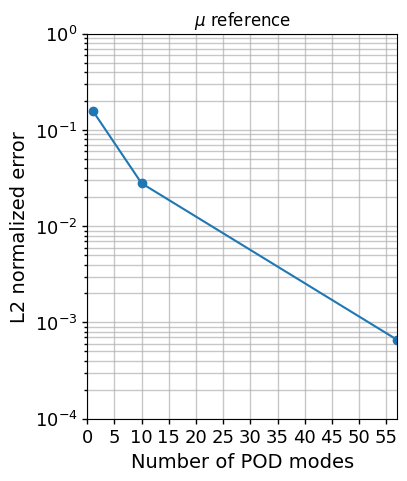

In [7]:
fig, (ax1) = plt.subplots(1, figsize=(4,5))
ax1.set_yscale('log')
ax1.plot(dimensions,max_errors_L2,  '-o')
ax1.tick_params(axis="y", which='both',labelsize=13,  width=1)
ax1.tick_params(axis='x', labelsize=13,  width=1)
ax1.set_xlabel('Number of POD modes',fontsize=14)
ax1.set_ylabel('L2 normalized error',fontsize=14)
#ax1.axvspan(1, NN, color='gray', alpha=0.2)
xticks = np.arange(0, 58, 5)  
ax1.set_xticks(xticks)
ax1.set_xlim([0, 57])
ax1.set_ylim([1e-4, 1])
ax1.set_title(rf'$\mu$ reference')
ax1.grid(visible=True, which='both', linewidth=1, alpha=0.7)
#plt.savefig(os.path.join('plot/Missing energy.pdf'), bbox_inches='tight')

## **L2 norm in time**

In [ ]:
dimensions = [1, 10, 57]
#list(range(1, 3))  # Da 1 a 57
num_time_steps = 1001
errors_L2 = np.zeros((dimensions.size, num_time_steps))
max_errors_L2 = []


MM_FO = np.load('model_files/XX_FO.npy', allow_pickle=True)[0]  # Matrice per norma L2
with h5py.File('../2. DEIM-POD/matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    ZZ_CO = hf['ZZ_CO'][:]
    II_CO = hf['II_CO'][:]

# Itera sulle dimensioni delle basi ridotte
for dim in dimensions:
    max_error_for_dim = 0  # Errore massimo per la dimensione corrente

    # Itera sui set di parametri
    for i in range(3):
        cur_FR = LIST_FR[i]
        cur_BC = LIST_BC[i]
        cur_LL = LIST_LL[i]
        cur_RR = LIST_RR[i]
        cur_FY = LIST_FY[i]
        cur_K = LIST_K[i]
        cur_dt = 1.00E+04

        print(f"Iterazione {i+1}/{sTR} - Parametri: "
          f"FR={cur_FR:.2e}, BC={cur_BC:.2f}, LL={cur_LL:.2e}, "
          f"RR={cur_RR:.2e}, FY={cur_FY:.2f}, K={cur_K:.2f}")
    
        # Calcola la soluzione FOM con i parametri attuali
        solver_FO = FiniteElementCylinderSolver()
        solver_FO.assemble(RADIUS=cur_RR, LENGTH=cur_LL, F_RATE=cur_FR, 
                        F_YIELD=cur_FY, T_BC=cur_BC, KTH=cur_K, dt=cur_dt)
        FOM = solver_FO.solve(n_steps=1000, verbose=False)


        # Ricrea CC_CO per il set di parametri
        GAMMA_T = (cur_FR * FISSION_ENERGY * cur_LL**2) / cur_K
        SOURCE_C = cur_FR * cur_FY
        TT = cur_BC + GAMMA_T * (1 - ZZ_CO**2) / 2
        WW = 2.949513e-13 * np.exp(-20487.36244 / TT)
        CC_CO = np.hstack((II_CO @ WW / cur_RR**2, II_CO @ WW / cur_LL**2))

        # Carica le matrici ridotte
        with h5py.File('../2. DEIM-POD/matrici_RB.h5', 'r') as hf:
            MM_RB = hf['MM_RB'][:dim, :dim]
            FF_RB = hf['FF_RB'][:dim]
            KK_RB = hf['KK_RB'][:, :dim, :dim]
            AA_RB = hf['AA_RB'][:dim]
            basis = hf['basis'][:, :dim]
        
        # Inizializzazione della soluzione ridotta
        old_sol_RB = np.zeros((dim, 1))

        # Proiezione delle matrici nello spazio ridotto
        SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
        QQ_RB = SOURCE_C * FF_RB
        LHS_RB_static = MM_RB + cur_dt * SS_RB
        RHS_RB_static = cur_dt * QQ_RB

        ROM = np.zeros((num_time_steps))
        # Calcolo della soluzione ridotta
        for ii in range(1, 1001):
            old_sol_RB = np.linalg.solve(LHS_RB_static, RHS_RB_static + MM_RB.dot(old_sol_RB))
            ROM = np.dot(basis, old_sol_RB[:, 0])
            difference = FOM[:, ii] - ROM
            L2_norm = np.sqrt(MM_FO.dot(difference).dot(difference))
            reference_norm = np.sqrt(MM_FO.dot(FOM[:, ii]).dot(FOM[:, ii]))
            L2_normalized = L2_norm / reference_norm
            errors_L2[dim-1, ii] = L2_normalized

        # Salva l'array di errori per questo set di parametri
        errors_for_dim.append(errors_L2[dim-1, :].copy())  # Copia l'array

        # Calcola l'errore massimo per questo set di parametri
        max_error_current_params = np.max(errors_L2[dim-1, :])  # Max tra tutti i time step

        # Aggiorna l'errore massimo
        if max_error_current_params > max_error_for_dim:
            
            max_error_for_dim = max_error_current_params
        



        


        

        # Calcolo dell'errore in norma L2
        difference = solution_FO[:, 1000] - ROM
        L2_norm = np.sqrt(MM_FO.dot(difference).dot(difference))
        reference_norm = np.sqrt(MM_FO.dot(solution_FO[:, 1000]).dot(solution_FO[:, 1000]))
        L2_normalized = L2_norm / reference_norm

        # Aggiorna l'errore massimo
        max_error_for_dim = max(max_error_for_dim, L2_normalized)
        print(f'max error = {max_error_for_dim}')

    # Salva l'errore massimo per la dimensione corrente
    max_errors_L2.append(max_error_for_dim)
    print(f"Dim: {dim}, Max L2 normalized error: {max_error_for_dim}")

# Risultati finali
print("Dimensioni delle basi:", dimensions)
print("Errori massimi normalizzati in norma L2:", max_errors_L2)